In [1]:
import xgboost as xbg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import pickle
import joblib
from tqdm import tqdm

%matplotlib inline

In [2]:
def load_all(fname):
    return joblib.load(fname)
path = "/scratch/pbanerj6/sml-dataset/"
trainSamples = 75000

n_trainSamples = [100,500,1000,10000,20000,50000,75000]
X_train_all = load_all(path+"X_train_all.jblib")[:trainSamples]
X_val_all = load_all(path+"X_val_all.jblib")

In [3]:
def load_y(fname):
    return np.array(pickle.load(open(fname,"rb")))

y_train = load_y(path+"y_train.p")[:trainSamples]
y_val = load_y(path+"y_val.p")

In [4]:
from sklearn.tree import ExtraTreeClassifier
model1 = ExtraTreeClassifier(random_state=0)
#model.fit(X_train_all,y_train)
#model = XGBClassifier(n_jobs=-1,verbosity=2,n_estimators=100)

In [5]:
#model.fit(X_train_all,y_train,verbose=True,eval_set=[(X_val_all,y_val)])

In [6]:
from sklearn.model_selection import GridSearchCV
parameters = {'min_samples_split': range(5, 20, 5), 
              'max_depth': range(1, 20, 5),
             # 'criterion':['gini','entropy'],
             #  'splitter':['best','random'],
              # 'max_features':['auto','log2','None'],
               #'presort':['False','True']
             }
    

In [7]:
model1.get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [12]:
gs_clf = GridSearchCV(model1,parameters, cv=5, n_jobs=1, verbose=2)

In [13]:
#if __name__ == '__main__':    
model = gs_clf.fit(X_train_all, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ................. max_depth=1, min_samples_split=5, total=  14.3s
[CV] max_depth=1, min_samples_split=5 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   19.8s remaining:    0.0s


[CV] ................. max_depth=1, min_samples_split=5, total=  15.0s
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ................. max_depth=1, min_samples_split=5, total=  14.1s
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ................. max_depth=1, min_samples_split=5, total=  14.8s
[CV] max_depth=1, min_samples_split=5 ................................
[CV] ................. max_depth=1, min_samples_split=5, total=  14.6s
[CV] max_depth=1, min_samples_split=10 ...............................
[CV] ................ max_depth=1, min_samples_split=10, total=  14.7s
[CV] max_depth=1, min_samples_split=10 ...............................
[CV] ................ max_depth=1, min_samples_split=10, total=  14.6s
[CV] max_depth=1, min_samples_split=10 ...............................
[CV] ................ max_depth=1, min_samples_split=10, total=  14.8s
[CV] max_depth=1, min_samples_split=10 ...............................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 21.9min finished


In [14]:
print(model.best_params_)
for param_name in sorted(parameters.keys()):
    print("%s: %r" % (param_name, model.best_params_[param_name]))

{'max_depth': 6, 'min_samples_split': 5}
max_depth: 6
min_samples_split: 5


In [15]:
pickle.dump(model,open("ET_All_"+str(trainSamples)+"_.pkl",'wb'))

In [22]:
from sklearn.metrics import accuracy_score
preds_val = model.predict(X_val_all)
accuracy = accuracy_score(y_val, preds_val)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 53.77%


In [23]:
X_test_all = load_all("/scratch/pbanerj6/sml-dataset/X_test_all.jblib")
y_test = load_y("/scratch/pbanerj6/sml-dataset/y_test.p")

In [24]:
preds_test_probs = model.predict_proba(X_test_all)

In [25]:
preds_test_probs

array([[0.55256835, 0.44743165],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       ...,
       [0.55256835, 0.44743165],
       [0.55256835, 0.44743165],
       [0.55256835, 0.44743165]])

In [26]:
from scipy.stats import rankdata

def mrrs(out, labels):
#     print(out,labels)
    outputs = np.argmax(out,axis=1)
    mrr = 0.0 
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        mrr+=1/rank
    return mrr/len(labels)

def precision_at(out,labels,prank=1):
    count = 0
    for label,ranks in zip(labels,out):
        ranks = rankdata(ranks*-1)
        rank = ranks[label]
#         print(rank,ranks)
        if rank <= prank:
            count+=1
    return count/len(labels)

def mrrwrapper(qid2c,qid2indexmap,preds_prob):
    labels = []
    out = []
    for qid in qid2c.keys():
        scores = []
        for ix in qid2indexmap[qid]:
            if len(scores) < 6:
                scores.append(preds_prob[ix][1])
        if len(scores) < 6:
            continue
        out.append(scores)
        labels.append(int(qid2c[qid]))
    return mrrs(np.array(out),labels),precision_at(np.array(out),labels,1),precision_at(np.array(out),labels,3)

def load_ranking(fname):
    return pickle.load(open("/scratch/pbanerj6/sml-dataset/ranking_"+fname+".p","rb"))

In [27]:
valAccuracy = []
testAccuracy = []
mrrScore = []
from sklearn.metrics import accuracy_score
import time
# For each of training sample sizes
for eachTrain in n_trainSamples:
    
    # Model with best values from grid search
    bestModel = ExtraTreeClassifier(min_samples_split=model.best_params_['min_samples_split'],
                                       max_depth=model.best_params_['max_depth'],
                                     #  criterion=model.best_params_['criterion'],
                                     #  splitter=model.best_params_['splitter']
                                   )

    print("SampleSize:",eachTrain)
    
    stime=time.time()
    X_train_f = (X_train_all[:eachTrain])
    bestModel.fit(X_train_f,y_train[:eachTrain])   
    print("Train Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    X_val_f = (X_val_all)
    preds_val = bestModel.predict(X_val_f)
    accuracy = round(accuracy_score(y_val, preds_val),4)
    valAccuracy.append(accuracy)
    print("Validation Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Validation Time:%.2f sec"%(time.time()-stime))

    stime=time.time()
    X_test_f = (X_test_all)
    preds_test = bestModel.predict(X_test_f)
    accuracy = round(accuracy_score(y_test, preds_test),4)
    testAccuracy.append(accuracy)
    print("Test Accuracy: %.2f%%" % (accuracy * 100.0))
    print("Test Time:%.2f sec"%(time.time()-stime))
    
    stime=time.time()
    preds_test_probs = bestModel.predict_proba(X_test_f)
    qid2c,qid2indexmap = load_ranking("test")
    mrr = mrrwrapper(qid2c,qid2indexmap,preds_test_probs)
    mrrScore.append(mrr)
    print("MRR:",mrr)
    print("MRR Time:%.2f sec"%(time.time()-stime))
    
    #input()
print (valAccuracy)
print (testAccuracy)
print (mrrScore)

SampleSize: 100
Train Time:0.01 sec
Validation Accuracy: 49.39%
Validation Time:1.28 sec
Test Accuracy: 49.70%
Test Time:1.22 sec
MRR: (0.35615714285714245, 0.08666666666666667, 0.23133333333333334)
MRR Time:1.50 sec
SampleSize: 500
Train Time:0.05 sec
Validation Accuracy: 50.42%
Validation Time:1.23 sec
Test Accuracy: 50.45%
Test Time:1.22 sec
MRR: (0.3836341510341498, 0.114, 0.4073333333333333)
MRR Time:1.48 sec
SampleSize: 1000
Train Time:0.10 sec
Validation Accuracy: 50.15%
Validation Time:1.39 sec
Test Accuracy: 51.21%
Test Time:1.22 sec
MRR: (0.3884449735449726, 0.094, 0.4653333333333333)
MRR Time:1.48 sec
SampleSize: 10000
Train Time:1.08 sec
Validation Accuracy: 52.04%
Validation Time:1.78 sec
Test Accuracy: 51.34%
Test Time:1.37 sec
MRR: (0.39322053872053775, 0.09666666666666666, 0.486)
MRR Time:1.63 sec
SampleSize: 20000
Train Time:2.02 sec
Validation Accuracy: 53.18%
Validation Time:1.04 sec
Test Accuracy: 51.31%
Test Time:1.63 sec
MRR: (0.400091967291966, 0.1173333333333333

In [28]:
def accuracyVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,testAccuracy,label='TestAccuracy vs TrainData',marker='o')
    ax.plot(n_trainSamples,valAccuracy,label='ValAccuracy vs TrainData',marker='.')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("ET_All_Accuracy.png")
    #plt.show()

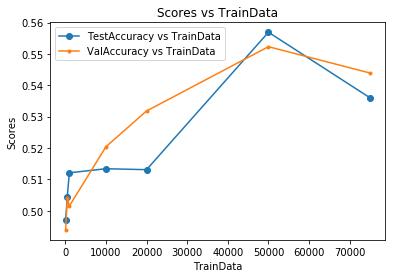

In [29]:
accuracyVisualization()

In [30]:
def mrrVisualization():
    ''' Plots the data points with the centroids
    '''
    fig = plt.figure()
    ax = plt.axes()
    ax.plot(n_trainSamples,mrrScore,label='MRR vs TrainData',marker='x')
    plt.title("Scores vs TrainData")
    plt.legend()
    plt.xlabel("TrainData")
    plt.ylabel("Scores")
    fig.savefig("ET_All_Mrr.png")
    plt.show()

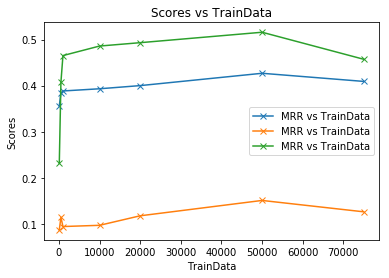

In [31]:
mrrVisualization()

In [32]:
from sklearn.metrics import accuracy_score

In [33]:
preds_val = model.predict(X_val_all)

In [34]:
accuracy = accuracy_score(y_val, preds_val)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 53.77%


In [35]:
X_test_all = load_all(path+"X_test_all.jblib")
y_test = load_y(path+"y_test.p")

In [36]:
preds_test = model.predict(X_test_all)
accuracy = accuracy_score(y_test, preds_test)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 54.19%


In [37]:
preds_test_probs = model.predict_proba(X_test_all)

In [38]:
preds_test_probs

array([[0.55256835, 0.44743165],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       ...,
       [0.55256835, 0.44743165],
       [0.55256835, 0.44743165],
       [0.55256835, 0.44743165]])

In [39]:
def load_ranking(fname):
    return pickle.load(open(path+"ranking_"+fname+".p","rb"))

In [40]:
qid2c,qid2indexmap = load_ranking("test")

In [41]:
mrrwrapper(qid2c,qid2indexmap,preds_test_probs)

(0.4339443963443954, 0.158, 0.5353333333333333)

In [42]:
preds_test_probs

array([[0.55256835, 0.44743165],
       [0.5       , 0.5       ],
       [0.5       , 0.5       ],
       ...,
       [0.55256835, 0.44743165],
       [0.55256835, 0.44743165],
       [0.55256835, 0.44743165]])